In [68]:
# 모듈 임포트
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib
import time
import psutil
import os

In [69]:
# 모델 및 스케일러 로드
model = joblib.load('./model/one_class_svm_model.joblib')
scaler = joblib.load('./model/scaler.joblib')

In [70]:
# Test 데이터셋 로드
column_names = ['timestamp', 'voltage', 'current', 'label']
test_df = pd.read_csv('../../data/test/test_dataset_187.csv', names=column_names, header=None)
test_df = test_df.dropna(subset=['voltage', 'current']).reset_index(drop=True)

In [71]:
# 파생 피처 생성 함수
def add_features(voltage_seq, current_seq):
    voltage = np.mean(voltage_seq)
    current = np.mean(current_seq)
    voltage_diff = np.abs(voltage_seq[-1] - voltage_seq[-2])
    current_diff = np.abs(current_seq[-1] - current_seq[-2])
    voltage_ma = np.mean(voltage_seq[-5:])
    current_ma = np.mean(current_seq[-5:])
    power = voltage * current
    power_diff = np.abs(power - (voltage_seq[-2] * current_seq[-2]))
    return [voltage, current, voltage_diff, current_diff, voltage_ma, current_ma, power, power_diff]

In [72]:
# 슬라이딩 윈도우 기반 피처 생성
def generate_sequence_features(df, window_size=8):
    features = []
    labels = []

    for i in range(window_size, len(df)):
        voltage_seq = df['voltage'].iloc[i - window_size:i].values
        current_seq = df['current'].iloc[i - window_size:i].values
        feat = add_features(voltage_seq, current_seq)
        features.append(feat)
        labels.append(df['label'].iloc[i])  # 마지막 인덱스의 라벨 사용

    return np.array(features), np.array(labels)

In [73]:
# 피처 및 라벨 생성
window_size = 8
X_test, y_test = generate_sequence_features(test_df, window_size=window_size)

# 정규화
X_test_scaled = scaler.transform(X_test)

In [74]:
# 예측
y_pred = model.predict(X_test_scaled)
y_pred_bin = (y_pred == -1).astype(int)

In [75]:
# 후처리 함수
def postprocess_anomalies(y_pred_bin, min_consecutive=2):
    y_post = np.zeros_like(y_pred_bin)
    count = 0
    for i, val in enumerate(y_pred_bin):
        if val == 1:
            count += 1
        else:
            if count >= min_consecutive:
                y_post[i - count:i] = 1
            count = 0
    if count >= min_consecutive:
        y_post[len(y_pred_bin)-count:] = 1
    return y_post

# 후처리 적용
y_pred_post = postprocess_anomalies(y_pred_bin, min_consecutive=2)

In [76]:
# 분류 리포트 출력
print("📋 (후처리 적용) 분류 리포트:\n")
print(classification_report(y_test, y_pred_post, target_names=['정상', '아크']))

📋 (후처리 적용) 분류 리포트:

              precision    recall  f1-score   support

          정상       0.99      0.79      0.88       180
          아크       0.00      0.00      0.00         1

    accuracy                           0.78       181
   macro avg       0.50      0.39      0.44       181
weighted avg       0.99      0.78      0.87       181



In [77]:
# 리소스 사용량 측정
process = psutil.Process(os.getpid())

# 예측 직전 리소스 측정
memory_before = process.memory_info().rss / 1024 ** 2
cpu_before = process.cpu_percent(interval=0.0)
start_time = time.perf_counter()

# 모델 예측
y_pred = model.predict(X_test_scaled)

# 예측 직후 리소스 측정
elapsed_time = time.perf_counter() - start_time
memory_after = process.memory_info().rss / 1024 ** 2
cpu_after = process.cpu_percent(interval=0.0)

# 리소스 사용량 계산
memory_used = memory_after - memory_before
cpu_used = cpu_after  # CPU 사용률은 절대값으로 출력

# 결과 출력
print(f"⏱️ 전체 예측 소요 시간: {elapsed_time:.6f}초")
print(f"🧠 예측 시 메모리 사용량 증가: {memory_used:.2f} MB")
print(f"🧮 예측 시 CPU 사용률: {cpu_used:.2f}%")

⏱️ 전체 예측 소요 시간: 0.002939초
🧠 예측 시 메모리 사용량 증가: 0.00 MB
🧮 예측 시 CPU 사용률: 0.00%


In [78]:
# 감지 지연 시간 계산 함수
def calculate_detection_delay(y_pred_bin, label, sampling_interval=0.001163):
    try:
        # 아크의 시작 인덱스 찾기
        arc_start = np.where(label == 1)[0][0]
        # 예측 값에서 아크를 처음 발견한 인덱스 찾기
        detected = np.where(y_pred_bin[arc_start:] == 1)[0]
        if len(detected) == 0:
            print("⚠️ 아크를 탐지하지 못했습니다.")
            return None
        detect_index = detected[0] + arc_start
        delay = detect_index - arc_start
        time_detected = detect_index * sampling_interval
        print(f"✅ 아크 시작 인덱스: {arc_start}")
        print(f"✅ 모델 이상 감지 인덱스: {detect_index}")
        print(f"⏱️ 감지 지연 시간: {delay} 샘플")
        print(f"⏱️ 감지된 시점 (초): {time_detected:.6f} 초")
        return arc_start, detect_index, delay
    except IndexError:
        print("⚠️ 라벨 데이터에 아크가 포함되어 있지 않습니다.")
        return None

# 감지 지연 시간 계산
result = calculate_detection_delay(y_pred_post, y_test)
if result is not None:
    arc_start, detect_index, delay = result
else:
    arc_start, detect_index, delay = None, None, None

⚠️ 아크를 탐지하지 못했습니다.


---
# 시각화 자료

In [79]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic'   # macOS 사용자
# plt.rcParams['font.family'] = 'NanumGothic'   # Linux 사용자 (Nanum 폰트 설치 필요)

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

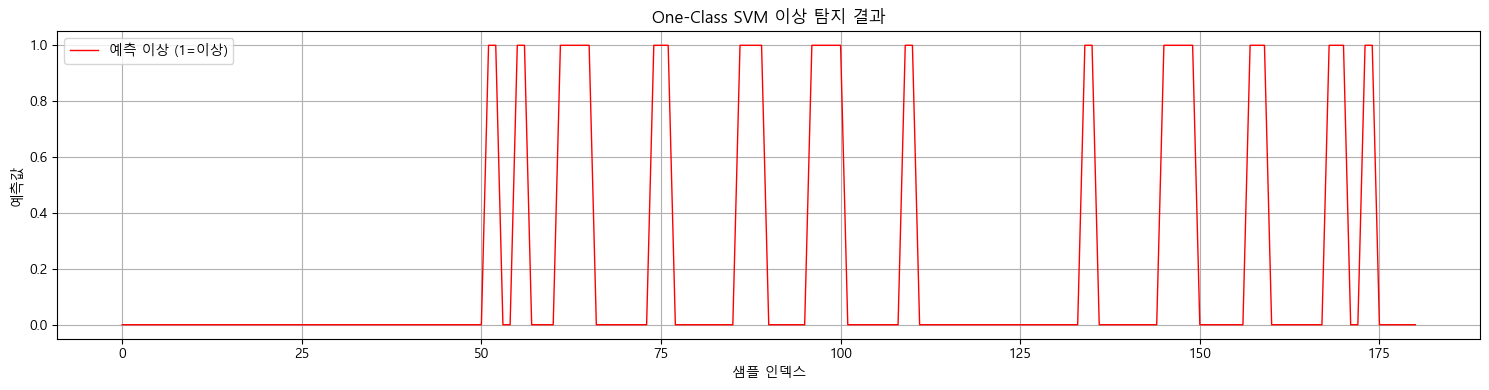

In [80]:
# 시각화 함수
def plot_predictions(y_pred_bin, arc_start=None, detect_index=None):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='예측 이상 (1=이상)', color='red', linewidth=1)

    if arc_start is not None:
        plt.axvline(x=arc_start, color='blue', linestyle='--', label='실제 아크 시작')
    if detect_index is not None:
        plt.axvline(x=detect_index, color='green', linestyle='--', label='감지된 시점')

    plt.title("One-Class SVM 이상 탐지 결과")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("예측값")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 시각화 호출
plot_predictions(y_pred_post, arc_start, detect_index)

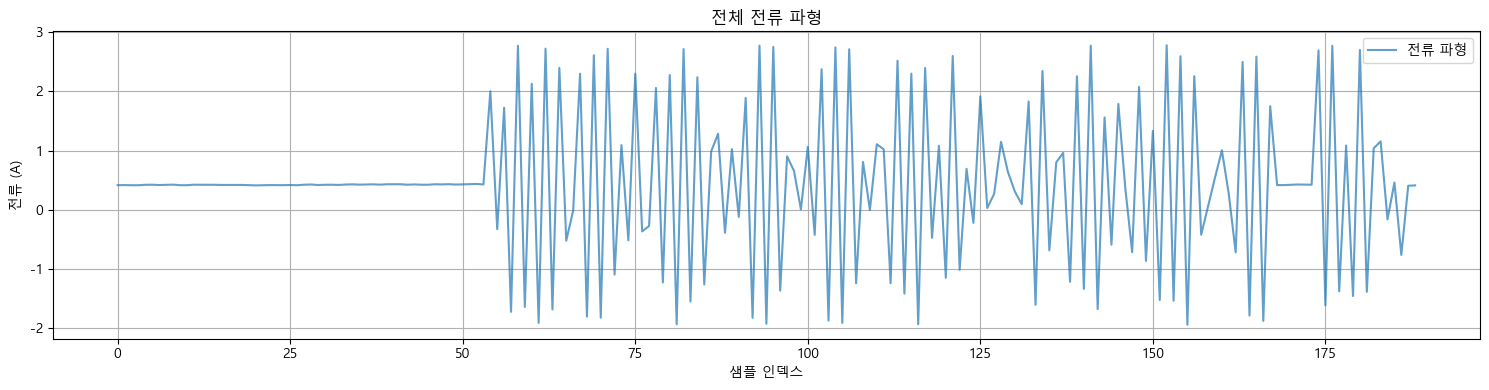

In [81]:
def plot_current_waveform(test_df):
    plt.figure(figsize=(15, 4))
    plt.plot(test_df['current'], label='전류 파형', alpha=0.7)
    plt.title("전체 전류 파형")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("전류 (A)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_current_waveform(test_df)

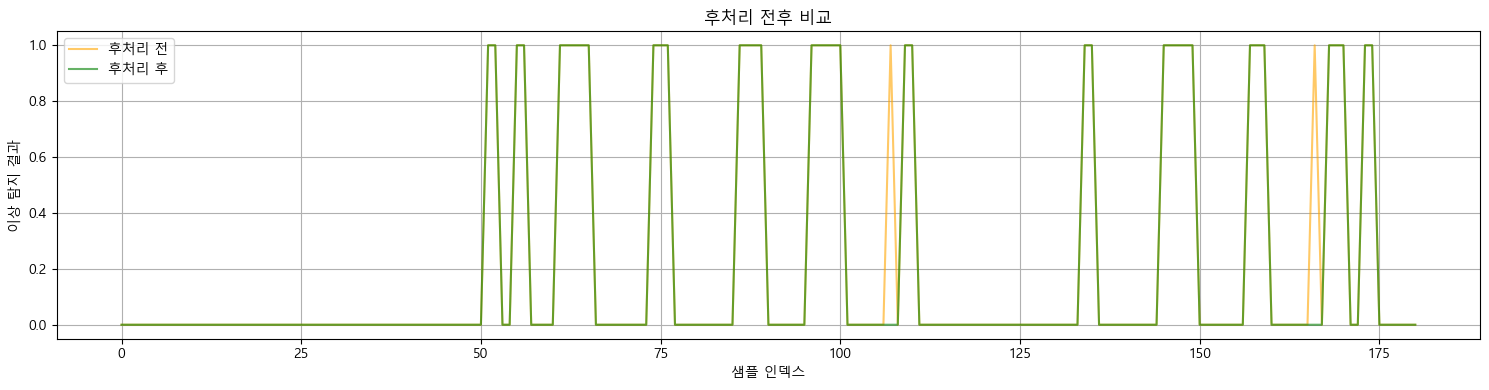

In [82]:
def compare_postprocessing(y_pred_bin, y_pred_post, title="후처리 전후 비교"):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='후처리 전', color='orange', alpha=0.6)
    plt.plot(y_pred_post, label='후처리 후', color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("샘플 인덱스")
    plt.ylabel("이상 탐지 결과")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_postprocessing(y_pred_bin, y_pred_post)


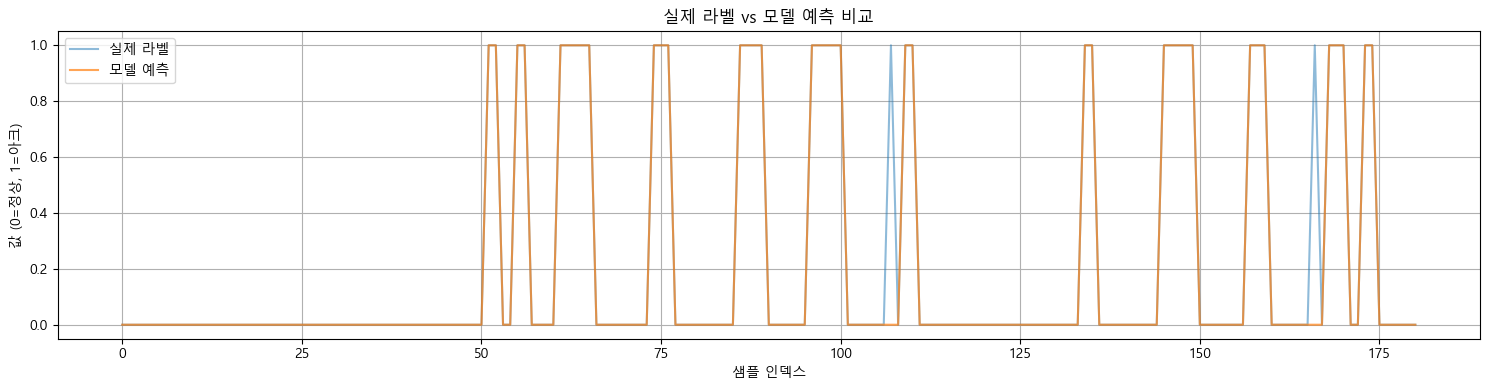

In [83]:
def compare_prediction_vs_label(y_true, y_pred_post):
    plt.figure(figsize=(15, 4))
    plt.plot(y_true, label='실제 라벨', alpha=0.5)
    plt.plot(y_pred_post, label='모델 예측', alpha=0.7)
    plt.title("실제 라벨 vs 모델 예측 비교")
    plt.xlabel("샘플 인덱스")
    plt.ylabel("값 (0=정상, 1=아크)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_prediction_vs_label(y_pred_bin, y_pred_post)
